# GAN et cGAN

In [150]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding, Multiply, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Données

Pour ce projet nous allons travailler avec les données MNIST celle-ci sont disponnible dans Keras et nous pouvons les charger avec la fonction load_mnist. Ce sont des images de chiffre manuscrits de 28 pixels par 28 pixels en noirs et blanc. Nous allons transformer les valeurs d'intensité entre 0 et 256 par des flottants entre -1 et 1 et mettons en forme les données dans des tenseurs aux dimensions adaptés.

In [151]:
# Chargement des données
(Xtrain, ytrain), (_, _) = mnist.load_data()
# Remise a l'échelle entre -1 et 1
Xtrain = Xtrain / 127.5 - 1.
Xtrain = np.expand_dims(Xtrain, axis=3)
ytrain = ytrain.reshape(-1,1)

Nous obtennons un tenseurs de 60 000 images de taille 28 par 28 avec 1 seul canal. 

In [152]:
Xtrain.shape

(60000, 28, 28, 1)

Vous pouvez grâce à cette cellule observer un exemple d'image tirer aléatoirement dans le jeux de données

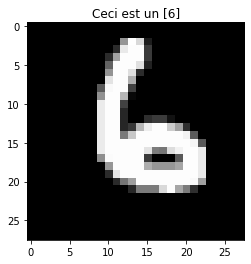

In [153]:
i = np.random.randint(0,Xtrain.shape[0])
img_s = Xtrain[i,:,:,0]
p=plt.imshow(img_s,cmap='gray')
t=plt.title("Ceci est un {}".format(ytrain[i]))

# GAN

Nous allons utliser ces images pour créer un GAN capable de générer des images de chiffres manuscrits réalistes. Dans cette première partie nous ne nous intéressons donc qu'a Xtrain comme données. Un gan est composé d'un générateur et d'un discriminateur dont les poids sont estimés conjoitement. Je vous rappel le schéma de fonctionnement de cette méthode :

![GAN](./gan.png "Gan")

Le code suivant contient le template d'une class GAN. 

In [170]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Construction et compilation du disciminateur
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        
        self.discriminator.summary()
        
        
        # Construction du générateur
        self.generator = self.build_generator()
        self.generator.summary()
        
        
        # Modèle combiné 
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        validity = self.discriminator(img)

        # Le modèle combiné permet de passer de z a une décision image réelle ou simulée
        self.combined = Model(z, validity)
        
        # Pour optimiser le générateur les poids du discriminateur doivent être fixés
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        

    def build_generator(self):
        
        # Inputs
        z = Input(shape=(self.latent_dim,))
        
        # Architecture RN :
        
        x = Dense(256)(z)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
       
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        
        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        
        x = Dense(self.img_rows*self.img_cols,activation='tanh')(x)
        
        # Output
        img = Reshape(self.img_shape)(x)      
        
        return Model(z, img)

    
    def build_discriminator(self):

        # Inputs
        img = Input(shape=self.img_shape)
        
        
        # Architecture RN :
        x = Flatten()(img)

        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x) 
        
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        
        # Output
        validity = Dense(1, activation = 'sigmoid')(x)
        
        return Model(img, validity)

    def train(self,X_train, epochs, batch_size=128, sample_interval=50):


        # vecteur de labels
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Apprentissage du discriminateur
            # ---------------------

            # Choisir des images réelles aléatoirement
            random_real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

            #Génerer des images fakes
            random_latent_vectors = np.random.normal(size=(batch_size, self.latent_dim))
            generated_images = self.generator.predict(random_latent_vectors)

            #Apprentissage discriminateur et enregistrement de coûts
            d_loss_real = self.discriminator.train_on_batch(random_real_images, valid)
            d_loss_fake = self.discriminator.train_on_batch(generated_images, fake)
            d_loss = [(d_loss_real[0]+d_loss_fake[0])/2,(d_loss_real[1]+d_loss_fake[1])/2]

            
            
            # ---------------------
            #  Apprentissage du générateur
            # ---------------------

            g_loss = self.combined.train_on_batch(random_latent_vectors, valid)

            ## CODE ##

            # Observons notre progressions de temps en temps
            if epoch % sample_interval == 0:
                 # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f,  acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0],100*d_loss[1]))
                self.sample_images(epoch)

                
    # fonction permettant de générer quelques images avec le générateur
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1

## GAN expérience 
Vous pouvez tester votre code avec les cellules suivante. La première ne fait qu'un tout petit apprentissage pour debugguer. La seconde un apprentissage plus conséquent.

Model: "model_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_290 (InputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_89 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_453 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_334 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_454 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_335 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_455 (Dense)            (None, 1)                 25

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


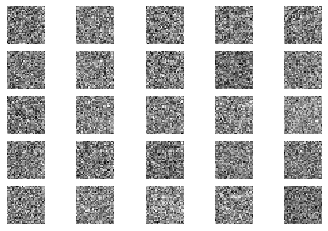

In [171]:
gan = GAN()
gan.train(Xtrain,epochs=200, batch_size=32, sample_interval=200)

Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_105 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
dense_149 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 512)               204

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.231040, acc.: 98.44%] [G loss: 2.873940,  acc.: 98.44%]
2000 [D loss: 0.201886, acc.: 90.62%] [G loss: 2.454439,  acc.: 90.62%]
3000 [D loss: 0.212165, acc.: 90.62%] [G loss: 2.315805,  acc.: 90.62%]
4000 [D loss: 0.217552, acc.: 93.75%] [G loss: 2.147157,  acc.: 93.75%]
5000 [D loss: 0.241893, acc.: 85.94%] [G loss: 2.276384,  acc.: 85.94%]
6000 [D loss: 0.254587, acc.: 90.62%] [G loss: 2.393781,  acc.: 90.62%]
7000 [D loss: 0.349587, acc.: 81.25%] [G loss: 1.891186,  acc.: 81.25%]
8000 [D loss: 0.202791, acc.: 89.06%] [G loss: 2.695609,  acc.: 89.06%]
9000 [D loss: 0.289262, acc.: 85.94%] [G loss: 2.536795,  acc.: 85.94%]
10000 [D loss: 0.309369, acc.: 87.50%] [G loss: 2.609207,  acc.: 87.50%]
11000 [D loss: 0.185521, acc.: 92.19%] [G loss: 2.788919,  acc.: 92.19%]
12000 [D loss: 0.290476, acc.: 87.50%] [G loss: 2.896900,  acc.: 87.50%]
13000 [D loss: 0.185364, acc.: 93.75%] [G loss: 2.717658,  acc.: 93.75%]
14000 [D loss: 0.161710, acc.: 93.75%] [G loss: 2.688277,  a

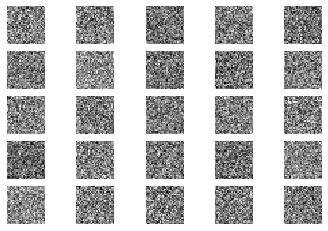

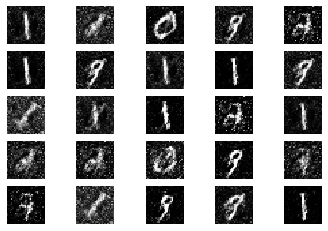

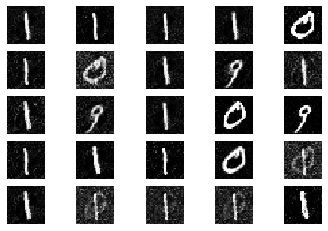

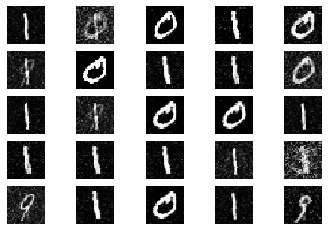

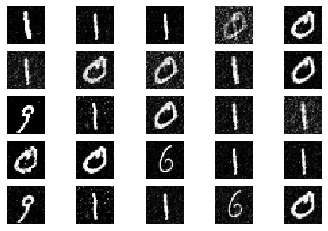

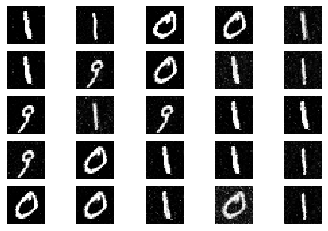

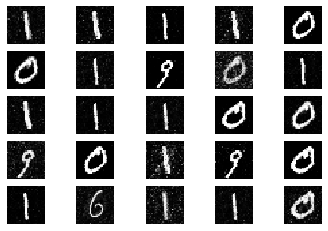

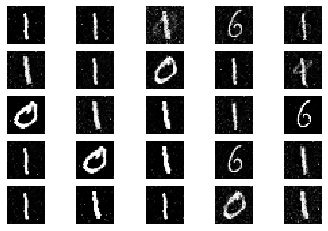

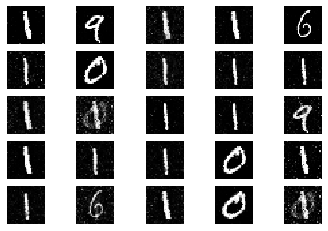

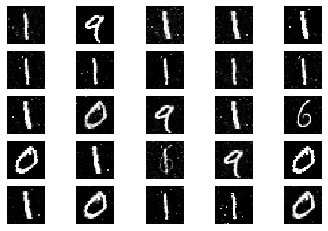

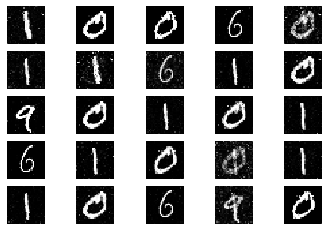

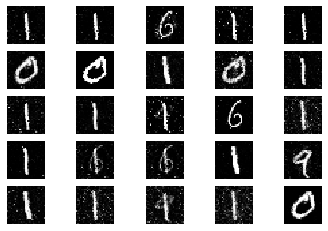

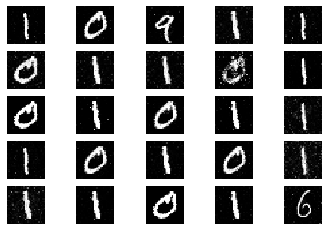

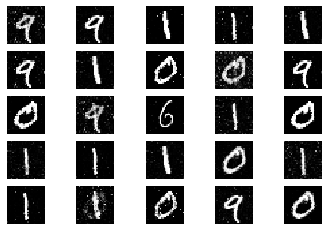

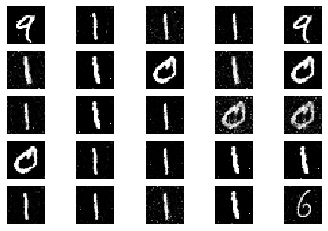

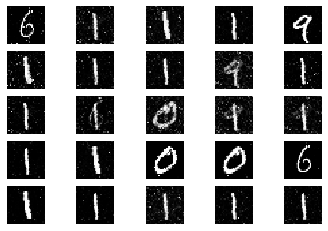

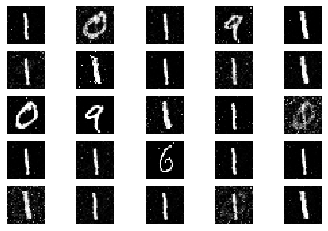

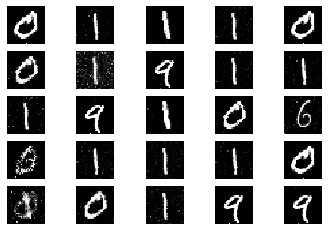

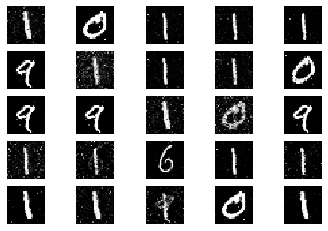

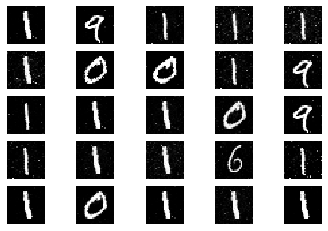

In [65]:
gan = GAN()
gan.train(Xtrain,epochs=20000, batch_size=32, sample_interval=1000)

# CGAN

Nous allons maintenant utliser ces images et leurs labels pour créer un GAN Conditionel capable de générer des images de chiffres manuscrits réalistes à partir d'un chiffre données en entrée. Dans cette première partie nous ne nous intéressons donc qu'a Xtrain comme données. Un gan est composé d'un générateur et d'un discriminateur dont les poids sont estimés conjoitement. Je vous rappel le schéma de fonctionnement de cette méthode :

![GAN](./cgan.png "Gan")

Le code suivant contient le template d'une class GAN. 

In [174]:
class CGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        
        # nombre de classes
        self.num_classes = 10

        optimizer = Adam(0.0002, 0.5)

        # Construction et compilation du disciminateur
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        
        # Construction du générateur
        self.generator = self.build_generator()
        
        # Pour optimiser les paramètres du générateur nous devons le coupler au discriminateur
        # Le modèle combiné 
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        
        # Il construit ensuite une image avec le génarateur
        img = self.generator([z,label])

        # Et la passe au discriminateur accompagné de son label
        validity = self.discriminator([img, label])

        # Définir le modèle combiné qui permet de passer de z a une décision image réelle ou simulée 
        self.combined = Model([z,label], validity)
        self.discriminator.trainable = False
        self.combined.compile(loss=['binary_crossentropy'], optimizer=optimizer)

    def build_generator(self):

        # Inputs
        
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        
        # Architecture RN :
        lb = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        xmul = multiply([lb,z])
        
        x = Dense(256)(xmul)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)

        x = Dense(1024)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(self.img_rows*self.img_cols,activation='tanh')(x)
        
        # Output
        img = Reshape(self.img_shape)(x)
        
        

        return Model([z, label], img)

    def build_discriminator(self):

        
        # Inputs
        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        
        
        
        # Architecture RN :
        img_p = Flatten()(img)
        lb = Flatten()(Embedding(self.num_classes, self.img_rows*self.img_cols)(label))
        x = multiply([img_p,lb])
        
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(p=0.4)(x)
        
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(p=0.4)(x)
        
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(p=0.4)(x)
        
        # Output
        validity = Dense(1, activation='sigmoid')(x)

        return Model([img, label], validity)

    def train(self,X_train, y_train, epochs, batch_size=128, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Apprentissage du discriminateur
            # ---------------------
            
            # Choisir les images réelles
            indx = np.random.randint(0, X_train.shape[0], batch_size)
            random_real_images, real_labels = X_train[indx], y_train[indx]

            # Genérer des images aléatoires
            
            random_latent_vectors = np.random.normal(0, 1, (batch_size, self.latent_dim))
            generated_images = self.generator.predict([random_latent_vectors, real_labels])

            # Apprentissage et enregegistrer les coûts

        
            d_loss_real = self.discriminator.train_on_batch([random_real_images, real_labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([generated_images, real_labels], fake)
            d_loss = [(d_loss_real[0]+d_loss_fake[0])/2,(d_loss_real[1]+d_loss_fake[1])/2]
           
            
            # ---------------------
            #  Apprentissage du générateur
            # ---------------------

            
            # Génerer des labels aléatoires
            random_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
            
            # Apprentissage
            g_loss = self.combined.train_on_batch([random_latent_vectors, random_labels], valid)

            # Observons notre progressions de temps en temps
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

                
    # Definir l'observation des images créees            
                
    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1

## CGAN expérience 
Vous pouvez tester votre code avec les cellules suivante. La première ne fait qu'un tout petit apprentissage pour debugguer. La seconde un apprentissage plus conséquent.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.696595, acc.: 18.75%] [G loss: 0.682747]


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200 [D loss: 0.295367, acc.: 85.94%] [G loss: 3.768653]
400 [D loss: 0.480906, acc.: 73.44%] [G loss: 2.142798]
600 [D loss: 0.462596, acc.: 78.12%] [G loss: 1.554181]
800 [D loss: 0.551703, acc.: 73.44%] [G loss: 1.752432]


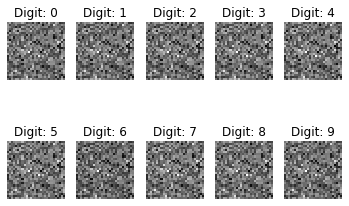

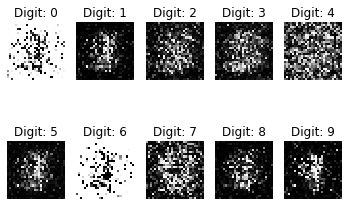

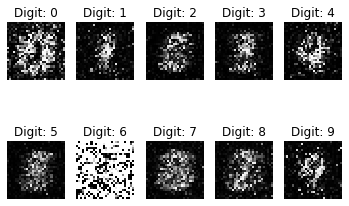

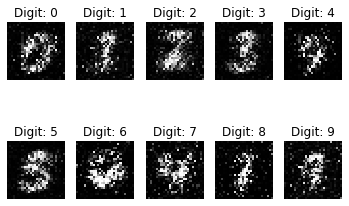

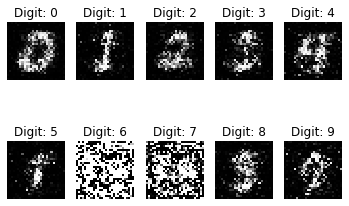

In [175]:
gan = CGAN()
gan.train(Xtrain,ytrain,epochs=1000, batch_size=32, sample_interval=200)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.4)`
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.689275, acc.: 42.19%] [G loss: 0.675096]


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200 [D loss: 0.327465, acc.: 84.38%] [G loss: 3.295142]
400 [D loss: 0.486969, acc.: 70.31%] [G loss: 2.273218]
600 [D loss: 0.566532, acc.: 70.31%] [G loss: 1.329503]
800 [D loss: 0.521482, acc.: 70.31%] [G loss: 1.376703]
1000 [D loss: 0.653186, acc.: 60.94%] [G loss: 1.369359]
1200 [D loss: 0.509810, acc.: 75.00%] [G loss: 1.205886]
1400 [D loss: 0.538459, acc.: 78.12%] [G loss: 1.184446]
1600 [D loss: 0.555534, acc.: 70.31%] [G loss: 1.148388]
1800 [D loss: 0.636815, acc.: 64.06%] [G loss: 1.020992]
2000 [D loss: 0.689367, acc.: 57.81%] [G loss: 0.820937]
2200 [D loss: 0.663451, acc.: 57.81%] [G loss: 0.857216]
2400 [D loss: 0.610641, acc.: 67.19%] [G loss: 0.862992]
2600 [D loss: 0.688103, acc.: 48.44%] [G loss: 0.875271]
2800 [D loss: 0.681798, acc.: 62.50%] [G loss: 0.789890]
3000 [D loss: 0.698459, acc.: 50.00%] [G loss: 0.738864]
3200 [D loss: 0.639642, acc.: 68.75%] [G loss: 0.789596]
3400 [D loss: 0.714077, acc.: 53.12%] [G loss: 0.760181]
3600 [D loss: 0.713711, acc.: 48.44

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


4200 [D loss: 0.688473, acc.: 50.00%] [G loss: 0.753805]
4400 [D loss: 0.661245, acc.: 51.56%] [G loss: 0.807298]
4600 [D loss: 0.674445, acc.: 59.38%] [G loss: 0.718191]
4800 [D loss: 0.695395, acc.: 51.56%] [G loss: 0.760407]
5000 [D loss: 0.716649, acc.: 45.31%] [G loss: 0.765061]
5200 [D loss: 0.671828, acc.: 56.25%] [G loss: 0.712370]
5400 [D loss: 0.703923, acc.: 56.25%] [G loss: 0.758083]
5600 [D loss: 0.653372, acc.: 57.81%] [G loss: 0.770015]
5800 [D loss: 0.674778, acc.: 59.38%] [G loss: 0.737577]
6000 [D loss: 0.691051, acc.: 56.25%] [G loss: 0.748387]
6200 [D loss: 0.636837, acc.: 65.62%] [G loss: 0.771267]
6400 [D loss: 0.694249, acc.: 57.81%] [G loss: 0.806965]
6600 [D loss: 0.653082, acc.: 57.81%] [G loss: 0.786347]
6800 [D loss: 0.701864, acc.: 51.56%] [G loss: 0.774646]
7000 [D loss: 0.663029, acc.: 59.38%] [G loss: 0.717970]
7200 [D loss: 0.665650, acc.: 56.25%] [G loss: 0.750901]
7400 [D loss: 0.648917, acc.: 57.81%] [G loss: 0.776222]
7600 [D loss: 0.682019, acc.: 5

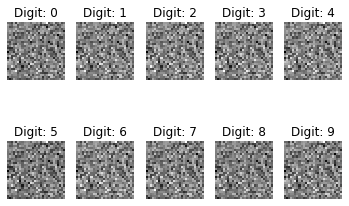

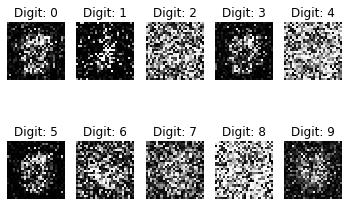

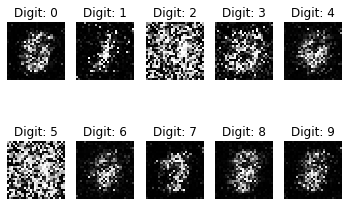

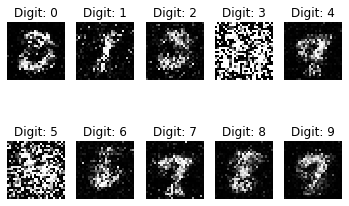

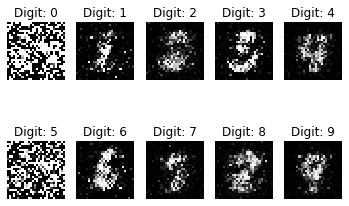

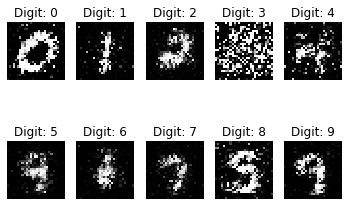

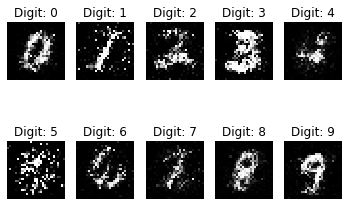

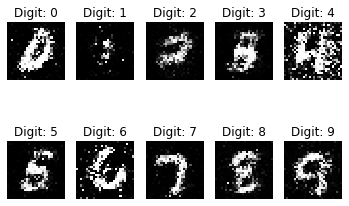

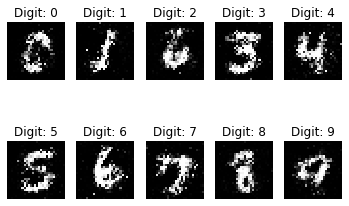

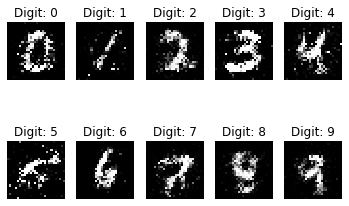

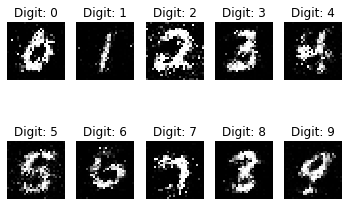

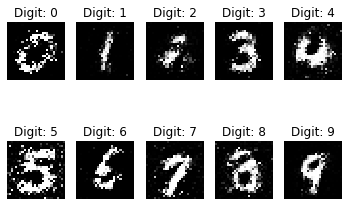

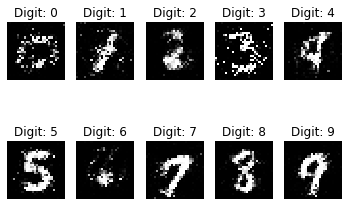

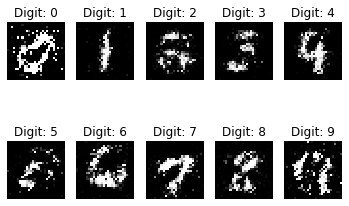

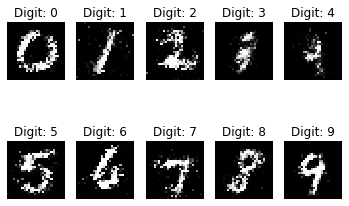

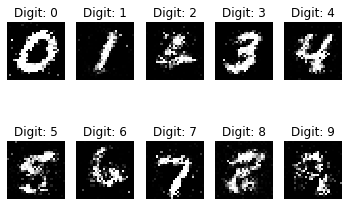

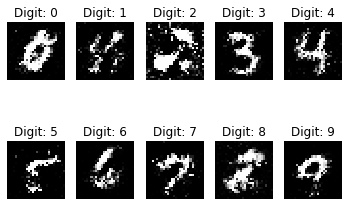

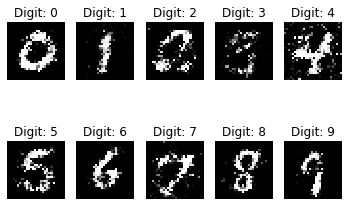

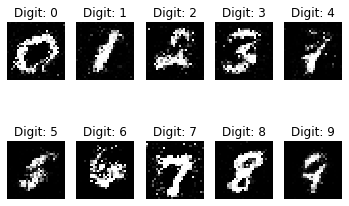

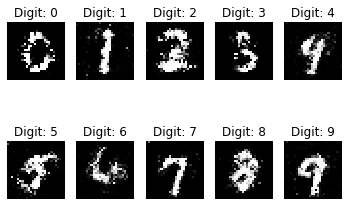

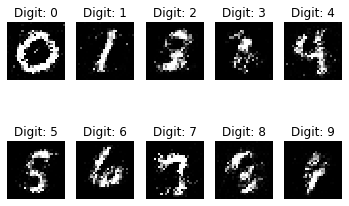

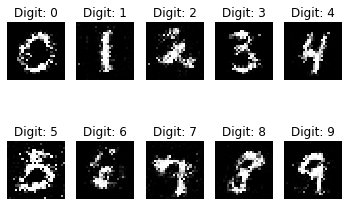

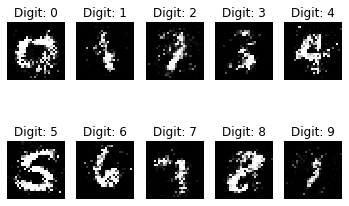

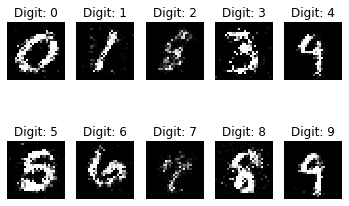

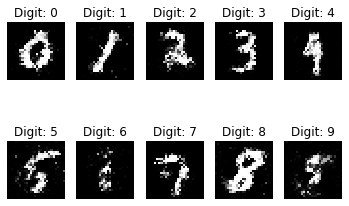

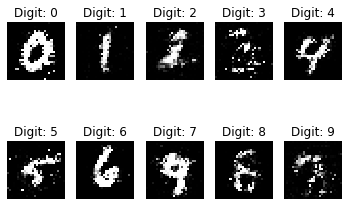

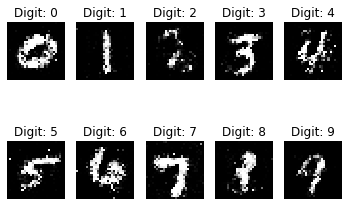

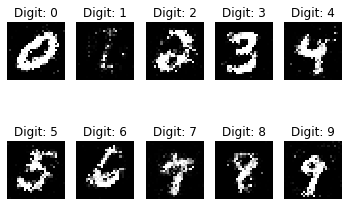

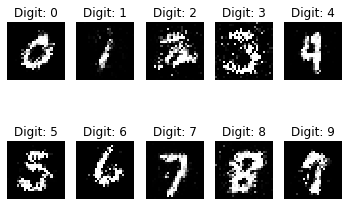

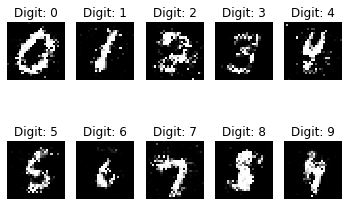

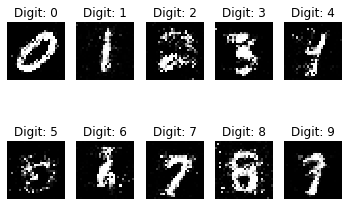

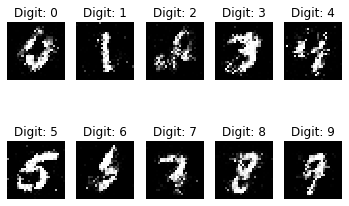

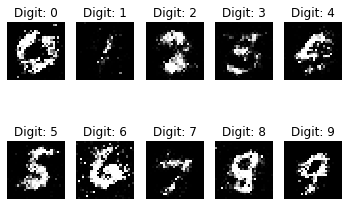

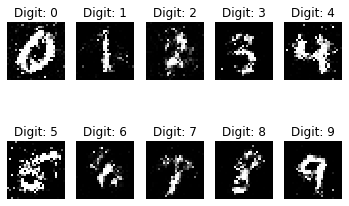

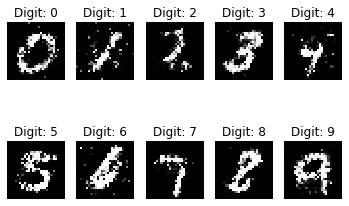

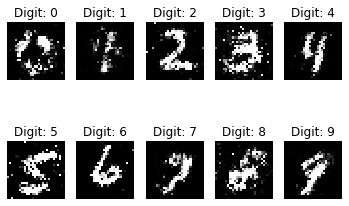

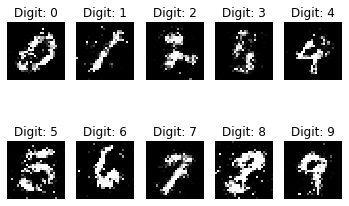

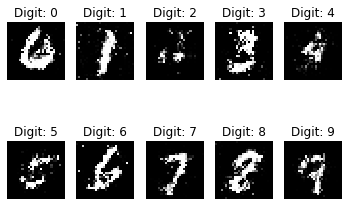

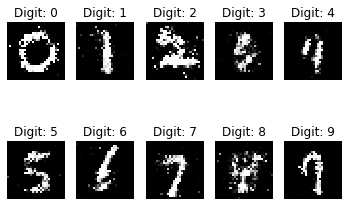

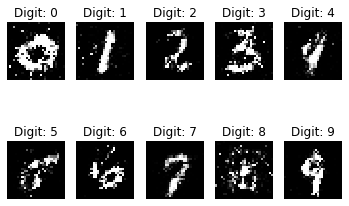

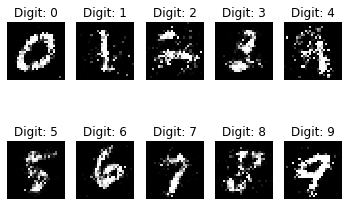

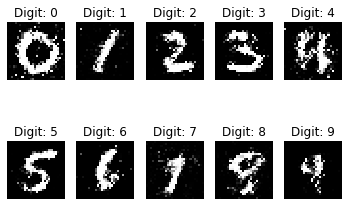

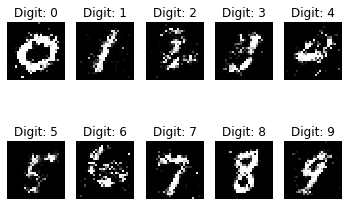

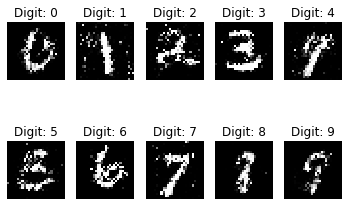

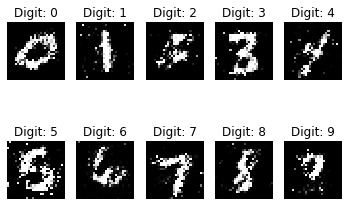

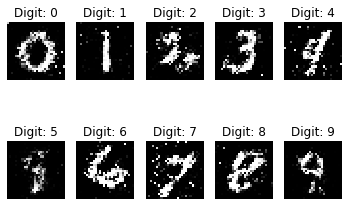

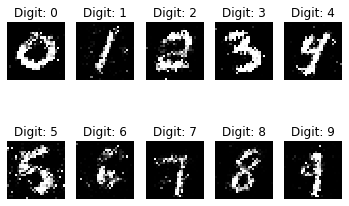

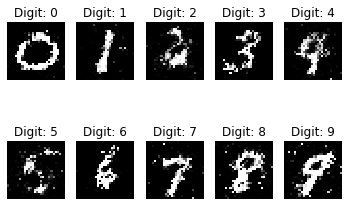

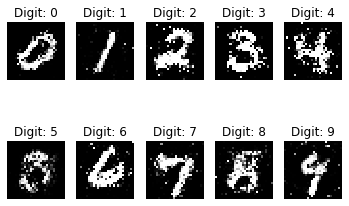

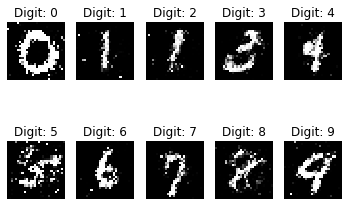

In [176]:
gan = CGAN()
gan.train(Xtrain,ytrain,epochs=10000, batch_size=32, sample_interval=200)